In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server

from matplotlib import pyplot
import numpy

Using TensorFlow backend.


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


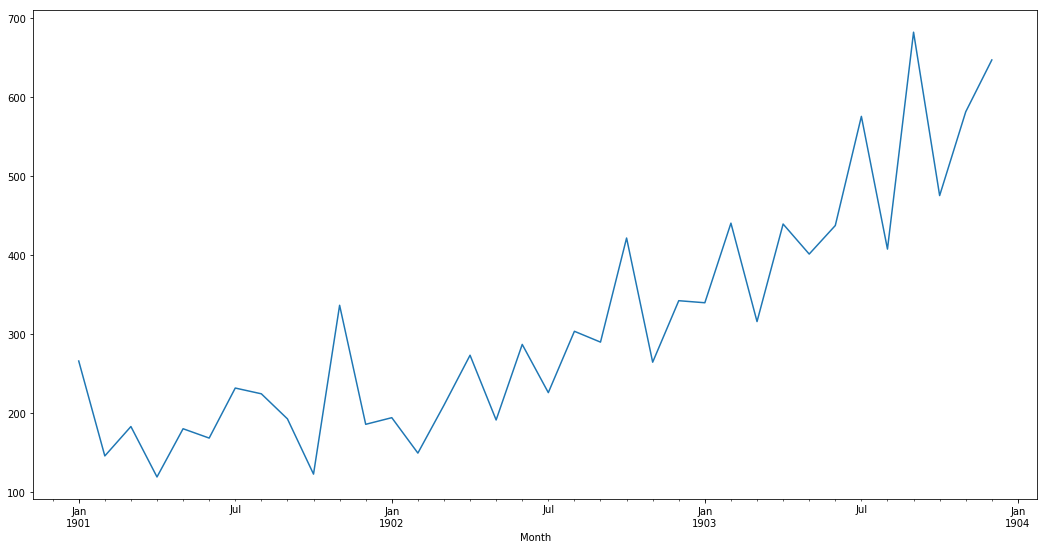

In [2]:
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('sales-of-shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
pyplot.figure(figsize = (18,9))
series.plot()
pyplot.show()

In [10]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=n_batch)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


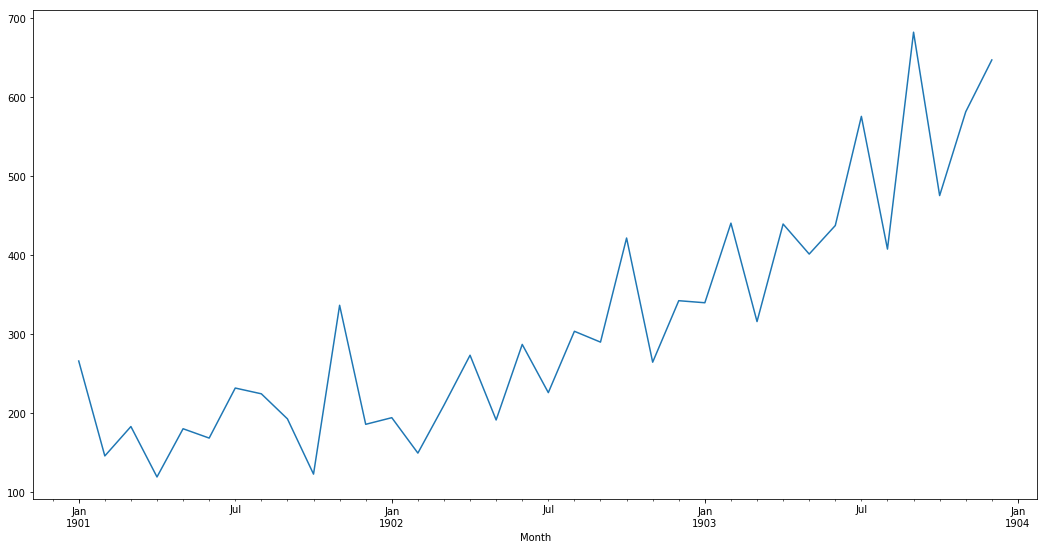

1) Test RMSE: 94.368
2) Test RMSE: 99.662
3) Test RMSE: 92.071
4) Test RMSE: 107.380
5) Test RMSE: 99.946
6) Test RMSE: 99.142
7) Test RMSE: 92.392
8) Test RMSE: 100.176
9) Test RMSE: 94.325
10) Test RMSE: 104.983
11) Test RMSE: 94.743
12) Test RMSE: 97.238
13) Test RMSE: 97.596
14) Test RMSE: 100.699
15) Test RMSE: 93.856
16) Test RMSE: 105.690
17) Test RMSE: 94.841
18) Test RMSE: 92.178
19) Test RMSE: 91.290
20) Test RMSE: 92.727
21) Test RMSE: 96.872
22) Test RMSE: 99.476
23) Test RMSE: 96.527
24) Test RMSE: 91.154
25) Test RMSE: 100.743
26) Test RMSE: 103.355
27) Test RMSE: 90.430
28) Test RMSE: 87.878
29) Test RMSE: 97.198
30) Test RMSE: 108.930
          results
count   30.000000
mean    97.262215
std      5.273557
min     87.877874
25%     93.009641
50%     97.034794
75%    100.118312
max    108.929941


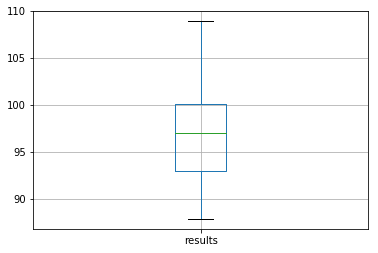

In [11]:
# load dataset
series = read_csv('sales-of-shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
pyplot.figure(figsize = (18,9))
series.plot()
pyplot.show()
# configure the experiment
n_lag = 1
n_repeats = 30
n_epochs = 1000
n_batch = 4
n_neurons = 3
# run the experiment
results = DataFrame()
results['results'] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('experiment_baseline.png')